In [13]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [14]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [15]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [53]:
files = glob('Cappello/Spinel_Barite/roi*.dat')
cnb_hcs = MixPhase([spinel,barite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(16).raw_snip(m=64)
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

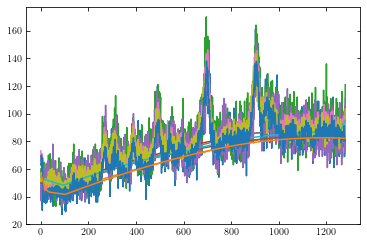

In [32]:
for s in xrd_spectra:
    plot(s.raw_intensity)
    plot(s.raw_snip)

N mixtures: 102
[-1219.88753071    51.66346471  1963.43877834]
[-1219.79271896    51.66346471  1963.16211777]
[-1219.85168579    51.66346471  1963.33061234]
[-1220.02205053    51.66346471  1963.53979206]
[-1220.03135299    51.66346471  1963.68236473]
[-1219.58616748    51.66346471  1963.48934307]
[-1219.77836542    51.66346471  1963.13499033]
[-1219.77836542    51.66346471  1963.13499033]
[-1219.833377      51.66346471  1963.29196516]
[-1220.00419623    51.66346471  1963.50246572]
[-1220.01384851    51.66346471  1963.64598079]
[-1219.57293323    51.66346471  1963.46530925]
[-1219.80772128    51.66346471  1963.1841558 ]
[-1219.80772128    51.66346471  1963.1841558 ]
[-1219.86746368    51.66346471  1963.35489849]
[-1220.03786827    51.66346471  1963.56425257]
[-1220.04713187    51.66346471  1963.70681942]
[-1219.60058624    51.66346471  1963.51060861]
[-1219.80772128    51.66346471  1963.1841558 ]
[-1219.80772128    51.66346471  1963.1841558 ]
[-1219.86745218    51.66346471  1963.3548649

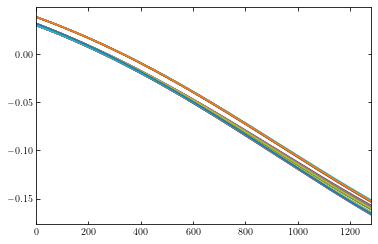

In [18]:
all_spinel = database['Spinel']
all_barite = database['Barite']
sb = []
for spinel in all_spinel:
    for barite in all_barite:
        sb += [MixPhase([spinel,barite])]
print('N mixtures:',len(sb))

x = arange(1280)
gn = []
for phase in sb:
    gn += [GaussNewton(phase,xrd_spectra[0])]
    
for g in gn[:]:
    for _ in range(64):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
    print(g.spectra.opt)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

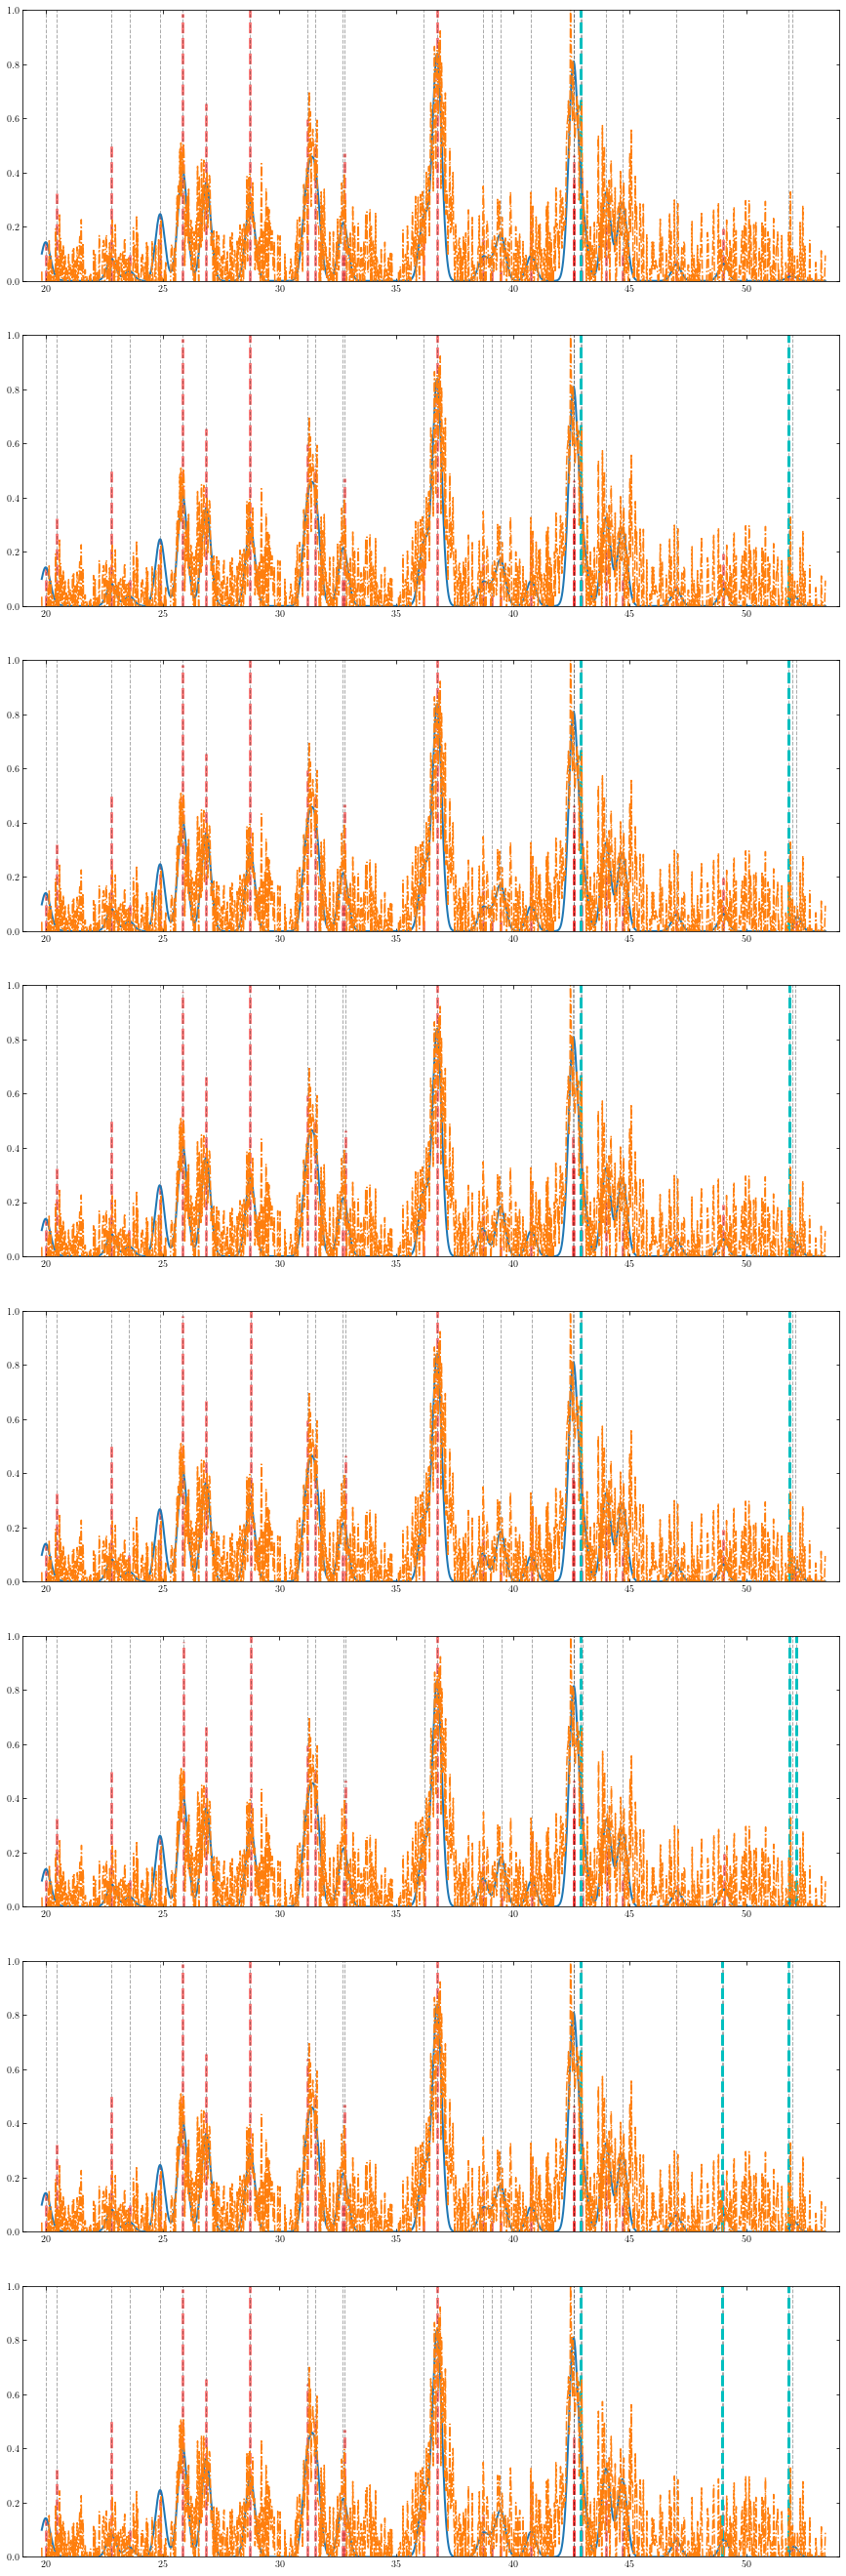

In [30]:
%matplotlib inline
fig,ax = subplots(8,1,figsize = (15,48))

for i,g in enumerate(gn[:8]):
    
    g.spectra.opt = g.opt.copy()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1219.85681575    51.66346471  1964.2702104 ]


(19.0, 53.0)

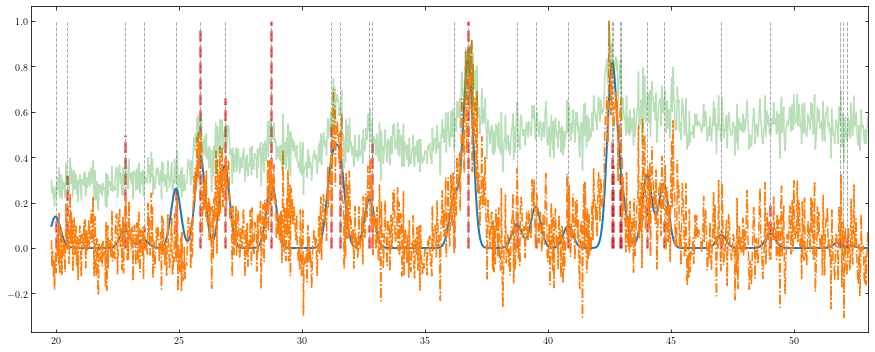

In [35]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(32):
    g.calibration_nobeta(alpha=1)  
print(g.spectra.opt)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
plot(s.theta,s.raw_intensity/s.raw_intensity.max(),'-',alpha=0.33)
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)

[-1219.85681575    51.66346471  1964.2702104 ]
[-1217.11928667    51.66346471  1960.12755111]
[-1218.44459282    51.66346471  1957.90873198]
[-1216.2121672     51.66346471  1953.97281832]
[-1213.18016773    51.66346471  1954.33939422]
[-1212.60670689    51.66346471  1947.09614121]


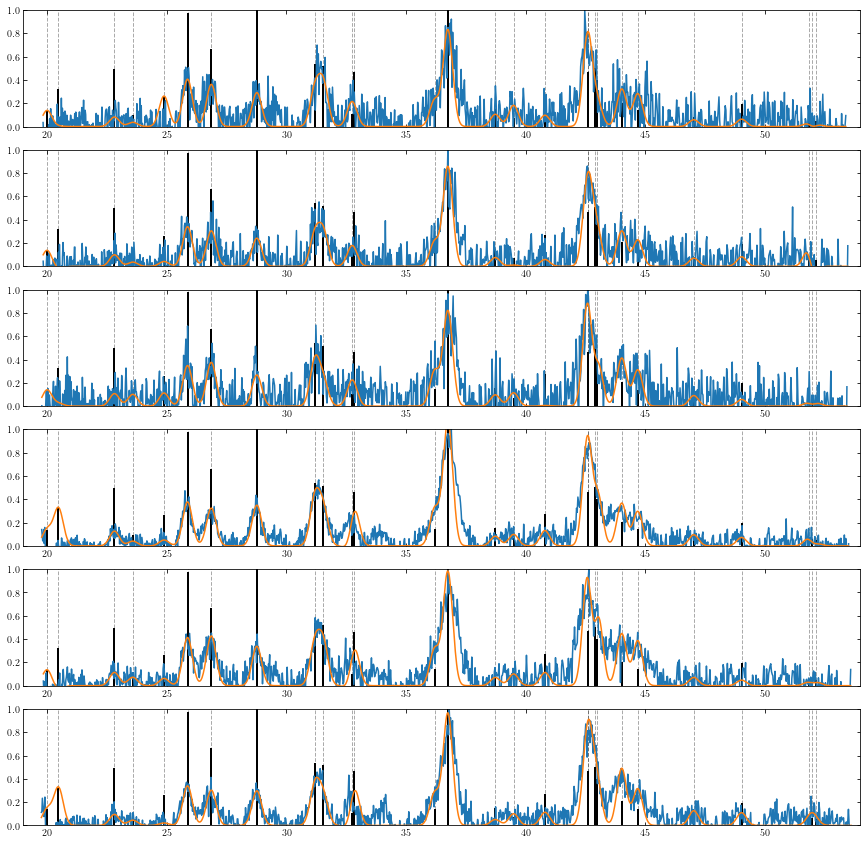

In [43]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(64):
        gn.calibration_nobeta(alpha=1)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1219.85681575    51.66346471  1964.2702104 ] [-1214.71937567    51.66346471  1952.7138947 ]
[-1217.11928667    51.66346471  1960.12755111] [-1214.71937567    51.66346471  1952.7138947 ]
[-1218.44459282    51.66346471  1957.90873198] [-1214.71937567    51.66346471  1952.7138947 ]
[-1216.2121672     51.66346471  1953.97281832] [-1214.71937567    51.66346471  1952.7138947 ]
[-1213.18016773    51.66346471  1954.33939422] [-1214.71937567    51.66346471  1952.7138947 ]
[-1212.60670689    51.66346471  1947.09614121] [-1214.71937567    51.66346471  1952.7138947 ]


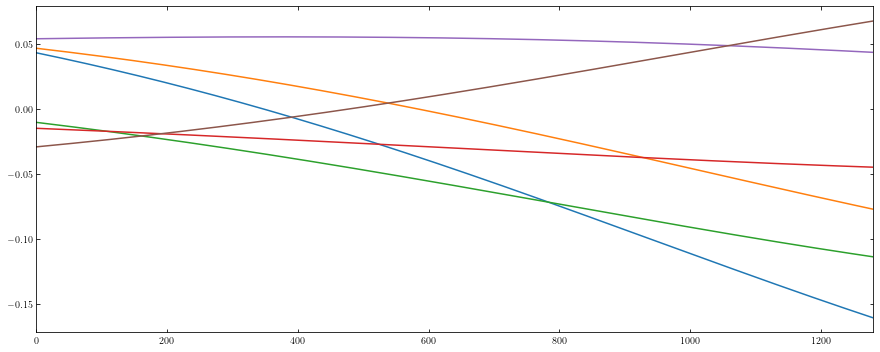

In [42]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
